# Stock Price Prediction Modeling

This notebook focuses on predicting target asset behavior using peer features as predictors.

## Training Configuration
- Training Period: 2020-01-01 to 2023-12-31
- Validation Splits: 5 (TimeSeriesSplit)
- Target: Close price prediction
- Features: Technical indicators from target and peer assets

In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, f_regression
import logging
import warnings
import pickle
import os

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)

logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

# Import the feature preparation module
from src.features.feature_model_prep import prepare_features, create_period_masks, validate_training_period

# Load configuration
with open('../config.yaml', 'r') as file:
    config = yaml.safe_load(file)


## Data Loading and Preprocessing

This section handles data loading and initial preprocessing steps for model training.

### Configuration
- Training Period: Loading from config file
- Data Source: Preprocessed features from all_features.pkl
- Timezone: America/New_York (ET)
- Feature Types: Technical indicators and market data

### Preprocessing Steps
1. Load and validate configuration
2. Filter data to training period
3. Remove data leakage features
4. Split features into target and peer sets
5. Create feature combinations
   - Peers only
   - Peers + target technical indicators

### Data Validation
- Minimum required data: 252 trading days
- Timezone consistency checks
- Feature completeness verification
- Leakage prevention measures

### Outputs
- Clean feature sets (X)
- Target variable (y)
- Data split information
- Feature filtering logs

In [4]:
# Load and prepare features
logger.info("Loading feature data...")
all_features = pd.read_pickle('../data/processed/all_features.pkl')

# Remove first 60 days of data
all_features = all_features.iloc[60:]

# Validate periods and create masks
periods = config['periods']
target_symbol = config['target_symbol']
peer_symbols = config['peer_symbols']
prediction_horizon = config['prediction_horizon']

# Create period masks
masks = create_period_masks(all_features, periods)

# Prepare features with config-based filtering
X_full, y_full, feature_names = prepare_features(
    all_features, 
    target_symbol, 
    peer_symbols,
    config
)

# Split data using masks
X_train = X_full[masks['training']]
y_train = y_full[masks['training']]
X_test = X_full[masks['test']]
y_test = y_full[masks['test']]
X_strategy = X_full[masks['strategy']]
y_strategy = y_full[masks['strategy']]

# Log data info
logger.info(f"\nData Split Summary:")
logger.info(f"Training samples: {len(X_train)}")
logger.info(f"Test samples: {len(X_test)}")
logger.info(f"Strategy samples: {len(X_strategy)}")

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Fit scalers on training data only
X_train_scaled = pd.DataFrame(
    feature_scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
y_train_scaled = pd.Series(
    target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel(),
    index=y_train.index
)

# Transform test and strategy data using training period scalers
X_test_scaled = pd.DataFrame(
    feature_scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)
X_strategy_scaled = pd.DataFrame(
    feature_scaler.transform(X_strategy),
    index=X_strategy.index,
    columns=X_strategy.columns
)
y_test_scaled = pd.Series(
    target_scaler.transform(y_test.values.reshape(-1, 1)).ravel(),
    index=y_test.index
)
y_strategy_scaled = pd.Series(
    target_scaler.transform(y_strategy.values.reshape(-1, 1)).ravel(),
    index=y_strategy.index
)


2025-06-05 16:53:53,335 - __main__ - INFO - Loading feature data...
2025-06-05 16:53:53,629 - src.features.feature_model_prep - INFO - Available columns: ['MSFT_Dividends', 'MSFT_Stock Splits', 'MSFT_RSI', 'MSFT_MACD', 'MSFT_Signal', 'MSFT_Histogram', 'MSFT_BB_Upper', 'MSFT_BB_Lower', 'MSFT_BB_Middle', 'MSFT_CCI', 'MSFT_STOCH_K', 'MSFT_STOCH_D', 'MSFT_ATR', 'MSFT_OBV', 'MSFT_OBV_SMA', 'MSFT_ICHIMOKU_CONV', 'MSFT_ICHIMOKU_BASE', 'MSFT_Close_sma_5', 'MSFT_Volume_sma_5', 'MSFT_High_sma_5', 'MSFT_Low_sma_5', 'MSFT_Close_sma_10', 'MSFT_Volume_sma_10', 'MSFT_High_sma_10', 'MSFT_Low_sma_10', 'MSFT_Close_sma_20', 'MSFT_Volume_sma_20', 'MSFT_High_sma_20', 'MSFT_Low_sma_20', 'MSFT_Close_sma_50', 'MSFT_Volume_sma_50', 'MSFT_High_sma_50', 'MSFT_Low_sma_50', 'MSFT_Close_lag_1', 'MSFT_Close_lag_2', 'MSFT_Close_lag_3', 'MSFT_Close_lag_5', 'MSFT_Close_lag_10', 'MSFT_Close_lag_20', 'MSFT_High_lag_1', 'MSFT_High_lag_2', 'MSFT_High_lag_3', 'MSFT_High_lag_5', 'MSFT_High_lag_10', 'MSFT_High_lag_20', 'MSFT_

In [5]:
# Comprehensive Data Cleaning for Linear Regression
print("=== COMPREHENSIVE DATA CLEANING FOR LINEAR REGRESSION ===")

# Check for missing values in features
print(f"\nOriginal feature data shape: {X_train_scaled.shape}")
print(f"Feature missing values per column:")
missing_counts = X_train_scaled.isnull().sum()
print(f"Columns with missing values: {(missing_counts > 0).sum()}")
print(f"Total missing values: {missing_counts.sum()}")

# Check for missing values in targets
print(f"\nTarget variable missing values:")
print(f"y_train NaN count: {y_train.isnull().sum()}")
print(f"y_test NaN count: {y_test.isnull().sum()}")
print(f"y_strategy NaN count: {y_strategy.isnull().sum()}")

# Remove rows where target variables are NaN
print(f"\nRemoving rows with NaN target values...")

# Training data
train_mask = ~y_train.isnull()
X_train_clean = X_train_scaled[train_mask].copy()
y_train_clean = y_train[train_mask].copy()
y_train_scaled_clean = y_train_scaled[train_mask].copy()

# Test data
test_mask = ~y_test.isnull()
X_test_clean = X_test_scaled[test_mask].copy()
y_test_clean = y_test[test_mask].copy()
y_test_scaled_clean = y_test_scaled[test_mask].copy()

# Strategy data
strategy_mask = ~y_strategy.isnull()
X_strategy_clean = X_strategy_scaled[strategy_mask].copy()
y_strategy_clean = y_strategy[strategy_mask].copy()
y_strategy_scaled_clean = y_strategy_scaled[strategy_mask].copy()

print(f"Data shapes after removing NaN targets:")
print(f"  Training: {X_train_clean.shape}")
print(f"  Test: {X_test_clean.shape}")
print(f"  Strategy: {X_strategy_clean.shape}")

# Remove columns with all missing values from features
all_nan_cols = X_train_clean.columns[X_train_clean.isnull().all()].tolist()
if all_nan_cols:
    print(f"\nRemoving {len(all_nan_cols)} columns with all missing values:")
    for col in all_nan_cols:
        print(f"  - {col}")
    
    X_train_clean = X_train_clean.drop(columns=all_nan_cols)
    X_test_clean = X_test_clean.drop(columns=all_nan_cols)
    X_strategy_clean = X_strategy_clean.drop(columns=all_nan_cols)

# Remove columns with high percentage of missing values (>50%)
missing_pct = X_train_clean.isnull().sum() / len(X_train_clean) * 100
high_missing_cols = missing_pct[missing_pct > 50].index.tolist()

if high_missing_cols:
    print(f"\nRemoving {len(high_missing_cols)} columns with >50% missing values:")
    for col in high_missing_cols:
        print(f"  - {col}: {missing_pct[col]:.1f}% missing")
    
    X_train_clean = X_train_clean.drop(columns=high_missing_cols)
    X_test_clean = X_test_clean.drop(columns=high_missing_cols)
    X_strategy_clean = X_strategy_clean.drop(columns=high_missing_cols)

# Fill remaining missing values with forward fill then backward fill
print(f"\nFilling remaining missing values...")
X_train_clean = X_train_clean.fillna(method='ffill').fillna(method='bfill')
X_test_clean = X_test_clean.fillna(method='ffill').fillna(method='bfill')
X_strategy_clean = X_strategy_clean.fillna(method='ffill').fillna(method='bfill')

# Final check for any remaining NaN values
remaining_nan_train = X_train_clean.isnull().sum().sum()
remaining_nan_test = X_test_clean.isnull().sum().sum()
remaining_nan_strategy = X_strategy_clean.isnull().sum().sum()

# If there are still NaN values, fill with 0
if remaining_nan_train > 0 or remaining_nan_test > 0 or remaining_nan_strategy > 0:
    print("Filling any remaining NaN with 0...")
    X_train_clean = X_train_clean.fillna(0)
    X_test_clean = X_test_clean.fillna(0)
    X_strategy_clean = X_strategy_clean.fillna(0)

print("Data cleaning complete!")



=== COMPREHENSIVE DATA CLEANING FOR LINEAR REGRESSION ===

Original feature data shape: (946, 885)
Feature missing values per column:
Columns with missing values: 15
Total missing values: 14190

Target variable missing values:
y_train NaN count: 0
y_test NaN count: 0
y_strategy NaN count: 5

Removing rows with NaN target values...
Data shapes after removing NaN targets:
  Training: (946, 885)
  Test: (252, 885)
  Strategy: (97, 885)

Removing 15 columns with all missing values:
  - MSFT_OBV_SMA
  - AAPL_OBV_SMA
  - AMZN_OBV_SMA
  - GOOGL_OBV_SMA
  - META_OBV_SMA
  - ORCL_OBV_SMA
  - IBM_OBV_SMA
  - CRM_OBV_SMA
  - ADBE_OBV_SMA
  - NVDA_OBV_SMA
  - INTC_OBV_SMA
  - SPY_OBV_SMA
  - QQQ_OBV_SMA
  - XLK_OBV_SMA
  - VTI_OBV_SMA

Filling remaining missing values...
Data cleaning complete!


## Model Training and Hyperparameter Optimization

This section implements XGBoost model training with hyperparameter tuning using RandomizedSearchCV.

### Hyperparameter Search Space
- max_depth: [3-8] Tree depth
- learning_rate: [0.01-0.2] Step size shrinkage
- n_estimators: [50-200] Number of trees
- min_child_weight: [1-5] Minimum sum of instance weight
- subsample: [0.6-0.9] Fraction of samples used
- colsample_bytree: [0.6-0.9] Fraction of features used

### Training Process
1. Scale features using StandardScaler
2. Convert to DMatrix format for XGBoost
3. Perform RandomizedSearchCV with time series splits
4. Train final model with best parameters
5. Early stopping to prevent overfitting

### Outputs
- Model performance metrics (MSE, R²)
- Feature importance rankings
- Actual vs Predicted visualizations
- Serialized model and predictions

In [6]:

# Linear Regression with Recursive Feature Elimination
print("\n=== LINEAR REGRESSION WITH STEPWISE SELECTION ===")
print("\n1. RECURSIVE FEATURE ELIMINATION (RFE)")
print("-" * 50)

# Start with a reasonable number of features
n_features_to_select = min(40, X_train_clean.shape[1] // 2)

# Initialize linear regression and RFE
lr_rfe = LinearRegression()
rfe_selector = RFE(
    estimator=lr_rfe, 
    n_features_to_select=n_features_to_select,
    step=1,
    verbose=1
)

# Fit RFE on cleaned training data using cleaned target
print(f"Selecting {n_features_to_select} features from {X_train_clean.shape[1]} total features...")
rfe_selector.fit(X_train_clean, y_train_scaled_clean)

# Get selected features
selected_features_rfe = X_train_clean.columns[rfe_selector.support_]
print(f"\nSelected features ({len(selected_features_rfe)}):")
for i, feature in enumerate(selected_features_rfe):
    print(f"{i+1:2d}. {feature}")

# Train final model with selected features
X_train_rfe = X_train_clean[selected_features_rfe]
X_test_rfe = X_test_clean[selected_features_rfe]
X_strategy_rfe = X_strategy_clean[selected_features_rfe]

lr_final_rfe = LinearRegression()
lr_final_rfe.fit(X_train_rfe, y_train_scaled_clean)

# Generate predictions using CLEANED indices
lr_predictions_rfe = {
    'training': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_train_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_train_clean.index
    ),
    'test': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_test_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_test_clean.index
    ),
    'strategy': pd.Series(
        target_scaler.inverse_transform(
            lr_final_rfe.predict(X_strategy_rfe).reshape(-1, 1)
        ).ravel(),
        index=X_strategy_clean.index
    )
}

# Calculate RFE metrics using CLEANED targets
lr_metrics_rfe = {
    'training': {
        'mse': mean_squared_error(y_train_clean, lr_predictions_rfe['training']),
        'r2': r2_score(y_train_clean, lr_predictions_rfe['training']),
        'mae': mean_absolute_error(y_train_clean, lr_predictions_rfe['training'])
    },
    'test': {
        'mse': mean_squared_error(y_test_clean, lr_predictions_rfe['test']),
        'r2': r2_score(y_test_clean, lr_predictions_rfe['test']),
        'mae': mean_absolute_error(y_test_clean, lr_predictions_rfe['test'])
    },
    'strategy': {
        'mse': mean_squared_error(y_strategy_clean, lr_predictions_rfe['strategy']),
        'r2': r2_score(y_strategy_clean, lr_predictions_rfe['strategy']),
        'mae': mean_absolute_error(y_strategy_clean, lr_predictions_rfe['strategy'])
    }
}

print("\nRFE Linear Regression Metrics:")
for period, period_metrics in lr_metrics_rfe.items():
    print(f"\n{period.capitalize()} Period:")
    print(f"  MSE: {period_metrics['mse']:.4f}")
    print(f"  R²:  {period_metrics['r2']:.4f}")
    print(f"  MAE: {period_metrics['mae']:.4f}")

# ============================================================================
# SAVE MODEL ARTIFACTS FOR STRATEGY NOTEBOOK
# ============================================================================

print("\n=== SAVING MODEL ARTIFACTS ===")

# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(models_dir, 'linear_regression_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(lr_final_rfe, f)
print(f"Linear regression model saved to: {model_path}")

# Save the feature scaler
feature_scaler_path = os.path.join(models_dir, 'lr_feature_scaler.pkl')
with open(feature_scaler_path, 'wb') as f:
    pickle.dump(feature_scaler, f)
print(f"Feature scaler saved to: {feature_scaler_path}")

# Save the target scaler
target_scaler_path = os.path.join(models_dir, 'lr_target_scaler.pkl')
with open(target_scaler_path, 'wb') as f:
    pickle.dump(target_scaler, f)
print(f"Target scaler saved to: {target_scaler_path}")

# Save the RFE selector
rfe_selector_path = os.path.join(models_dir, 'lr_rfe_selector.pkl')
with open(rfe_selector_path, 'wb') as f:
    pickle.dump(rfe_selector, f)
print(f"RFE selector saved to: {rfe_selector_path}")

# Save selected features list
selected_features_path = os.path.join(models_dir, 'lr_selected_features.pkl')
with open(selected_features_path, 'wb') as f:
    pickle.dump(list(selected_features_rfe), f)
print(f"Selected features saved to: {selected_features_path}")

# Save predictions for strategy analysis
predictions_path = os.path.join(models_dir, 'lr_predictions.pkl')
with open(predictions_path, 'wb') as f:
    pickle.dump(lr_predictions_rfe, f)
print(f"Predictions saved to: {predictions_path}")

# Save metrics
metrics_path = os.path.join(models_dir, 'lr_metrics.pkl')
with open(metrics_path, 'wb') as f:
    pickle.dump(lr_metrics_rfe, f)
print(f"Metrics saved to: {metrics_path}")

# Create a model info dictionary for easy loading
model_info = {
    'model_type': 'LinearRegression',
    'feature_selection': 'RFE',
    'n_features_selected': len(selected_features_rfe),
    'target_symbol': target_symbol,
    'prediction_horizon': prediction_horizon,
    'training_period': f"{periods['training']['start']} to {periods['training']['end']}",
    'test_period': f"{periods['test']['start']} to {periods['test']['end']}",
    'strategy_period': f"{periods['strategy']['start']} to {periods['strategy']['end']}",
    'performance': {
        'training_r2': lr_metrics_rfe['training']['r2'],
        'test_r2': lr_metrics_rfe['test']['r2'],
        'strategy_r2': lr_metrics_rfe['strategy']['r2']
    }
}

model_info_path = os.path.join(models_dir, 'lr_model_info.pkl')
with open(model_info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Model info saved to: {model_info_path}")



=== LINEAR REGRESSION WITH STEPWISE SELECTION ===

1. RECURSIVE FEATURE ELIMINATION (RFE)
--------------------------------------------------
Selecting 40 features from 870 total features...
Fitting estimator with 870 features.
Fitting estimator with 869 features.
Fitting estimator with 868 features.
Fitting estimator with 867 features.
Fitting estimator with 866 features.
Fitting estimator with 865 features.
Fitting estimator with 864 features.
Fitting estimator with 863 features.
Fitting estimator with 862 features.
Fitting estimator with 861 features.
Fitting estimator with 860 features.
Fitting estimator with 859 features.
Fitting estimator with 858 features.
Fitting estimator with 857 features.
Fitting estimator with 856 features.
Fitting estimator with 855 features.
Fitting estimator with 854 features.
Fitting estimator with 853 features.
Fitting estimator with 852 features.
Fitting estimator with 851 features.
Fitting estimator with 850 features.
Fitting estimator with 849 featu

In [7]:
# ============================================================================
# CREATE A PREDICTION FUNCTION FOR STRATEGY NOTEBOOK
# ============================================================================

def predict_linear_regression(features_df, models_dir='../models'):
    """
    Generate predictions using the trained linear regression model.
    
    Parameters:
    -----------
    features_df : pd.DataFrame
        Feature data with same structure as training data
    models_dir : str
        Directory containing saved model artifacts
        
    Returns:
    --------
    pd.Series
        Predictions in original scale
    """
    # Load model artifacts
    with open(os.path.join(models_dir, 'linear_regression_model.pkl'), 'rb') as f:
        model = pickle.load(f)
    
    with open(os.path.join(models_dir, 'lr_feature_scaler.pkl'), 'rb') as f:
        feature_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_target_scaler.pkl'), 'rb') as f:
        target_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_selected_features.pkl'), 'rb') as f:
        selected_features = pickle.load(f)
    
    # Clean and prepare features
    features_clean = features_df.copy()
    
    # Handle missing values the same way as training
    features_clean = features_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Scale features
    features_scaled = pd.DataFrame(
        feature_scaler.transform(features_clean),
        index=features_clean.index,
        columns=features_clean.columns
    )
    
    # Select the same features used in training
    features_selected = features_scaled[selected_features]
    
    # Generate predictions
    predictions_scaled = model.predict(features_selected)
    
    # Inverse transform to original scale
    predictions = target_scaler.inverse_transform(
        predictions_scaled.reshape(-1, 1)
    ).ravel()
    
    return pd.Series(predictions, index=features_df.index)

# Save the prediction function
prediction_function_path = os.path.join(models_dir, 'lr_predict_function.py')
with open(prediction_function_path, 'w') as f:
    f.write("""
import pandas as pd
import pickle
import os

def predict_linear_regression(features_df, models_dir='../models'):
    '''
    Generate predictions using the trained linear regression model.
    
    Parameters:
    -----------
    features_df : pd.DataFrame
        Feature data with same structure as training data
    models_dir : str
        Directory containing saved model artifacts
        
    Returns:
    --------
    pd.Series
        Predictions in original scale
    '''
    # Load model artifacts
    with open(os.path.join(models_dir, 'linear_regression_model.pkl'), 'rb') as f:
        model = pickle.load(f)
    
    with open(os.path.join(models_dir, 'lr_feature_scaler.pkl'), 'rb') as f:
        feature_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_target_scaler.pkl'), 'rb') as f:
        target_scaler = pickle.load(f)
        
    with open(os.path.join(models_dir, 'lr_selected_features.pkl'), 'rb') as f:
        selected_features = pickle.load(f)
    
    # Clean and prepare features
    features_clean = features_df.copy()
    
    # Handle missing values the same way as training
    features_clean = features_clean.fillna(method='ffill').fillna(method='bfill').fillna(0)
    
    # Scale features
    features_scaled = pd.DataFrame(
        feature_scaler.transform(features_clean),
        index=features_clean.index,
        columns=features_clean.columns
    )
    
    # Select the same features used in training
    features_selected = features_scaled[selected_features]
    
    # Generate predictions
    predictions_scaled = model.predict(features_selected)
    
    # Inverse transform to original scale
    predictions = target_scaler.inverse_transform(
        predictions_scaled.reshape(-1, 1)
    ).ravel()
    
    return pd.Series(predictions, index=features_df.index)
""")

print(f"Prediction function saved to: {prediction_function_path}")

print("\n=== MODEL ARTIFACTS SAVED SUCCESSFULLY ===")
print("Files saved:")
print(f"  - Model: {model_path}")
print(f"  - Feature scaler: {feature_scaler_path}")
print(f"  - Target scaler: {target_scaler_path}")
print(f"  - RFE selector: {rfe_selector_path}")
print(f"  - Selected features: {selected_features_path}")
print(f"  - Predictions: {predictions_path}")
print(f"  - Metrics: {metrics_path}")
print(f"  - Model info: {model_info_path}")
print(f"  - Prediction function: {prediction_function_path}")



Prediction function saved to: ../models\lr_predict_function.py

=== MODEL ARTIFACTS SAVED SUCCESSFULLY ===
Files saved:
  - Model: ../models\linear_regression_model.pkl
  - Feature scaler: ../models\lr_feature_scaler.pkl
  - Target scaler: ../models\lr_target_scaler.pkl
  - RFE selector: ../models\lr_rfe_selector.pkl
  - Selected features: ../models\lr_selected_features.pkl
  - Predictions: ../models\lr_predictions.pkl
  - Metrics: ../models\lr_metrics.pkl
  - Model info: ../models\lr_model_info.pkl
  - Prediction function: ../models\lr_predict_function.py


## Model Evaluation and Visualization

This section analyzes the model's performance and feature importance through metrics and visualizations.

### Performance Metrics
- Mean Squared Error (MSE): Measures prediction accuracy
- R-squared (R²): Indicates variance explained by model
- Feature Importance: Top predictive indicators

### Visualizations
1. **Feature Importance Plot**
   - Top 20 most influential features
   - Relative importance weights
   - Technical vs peer indicators

2. **Prediction Analysis**
   - Actual vs Predicted prices
   - Visual fit assessment
   - Trend capture evaluation

### Key Insights
- Model's predictive accuracy
- Most influential technical indicators
- Cross-asset relationships
- Potential areas for improvement

The visualizations help identify:
- Feature selection effectiveness
- Model's strength in different market conditions
- Potential overfitting or underfitting
- Areas needing feature engineering


=== LINEAR REGRESSION VISUALIZATIONS ===


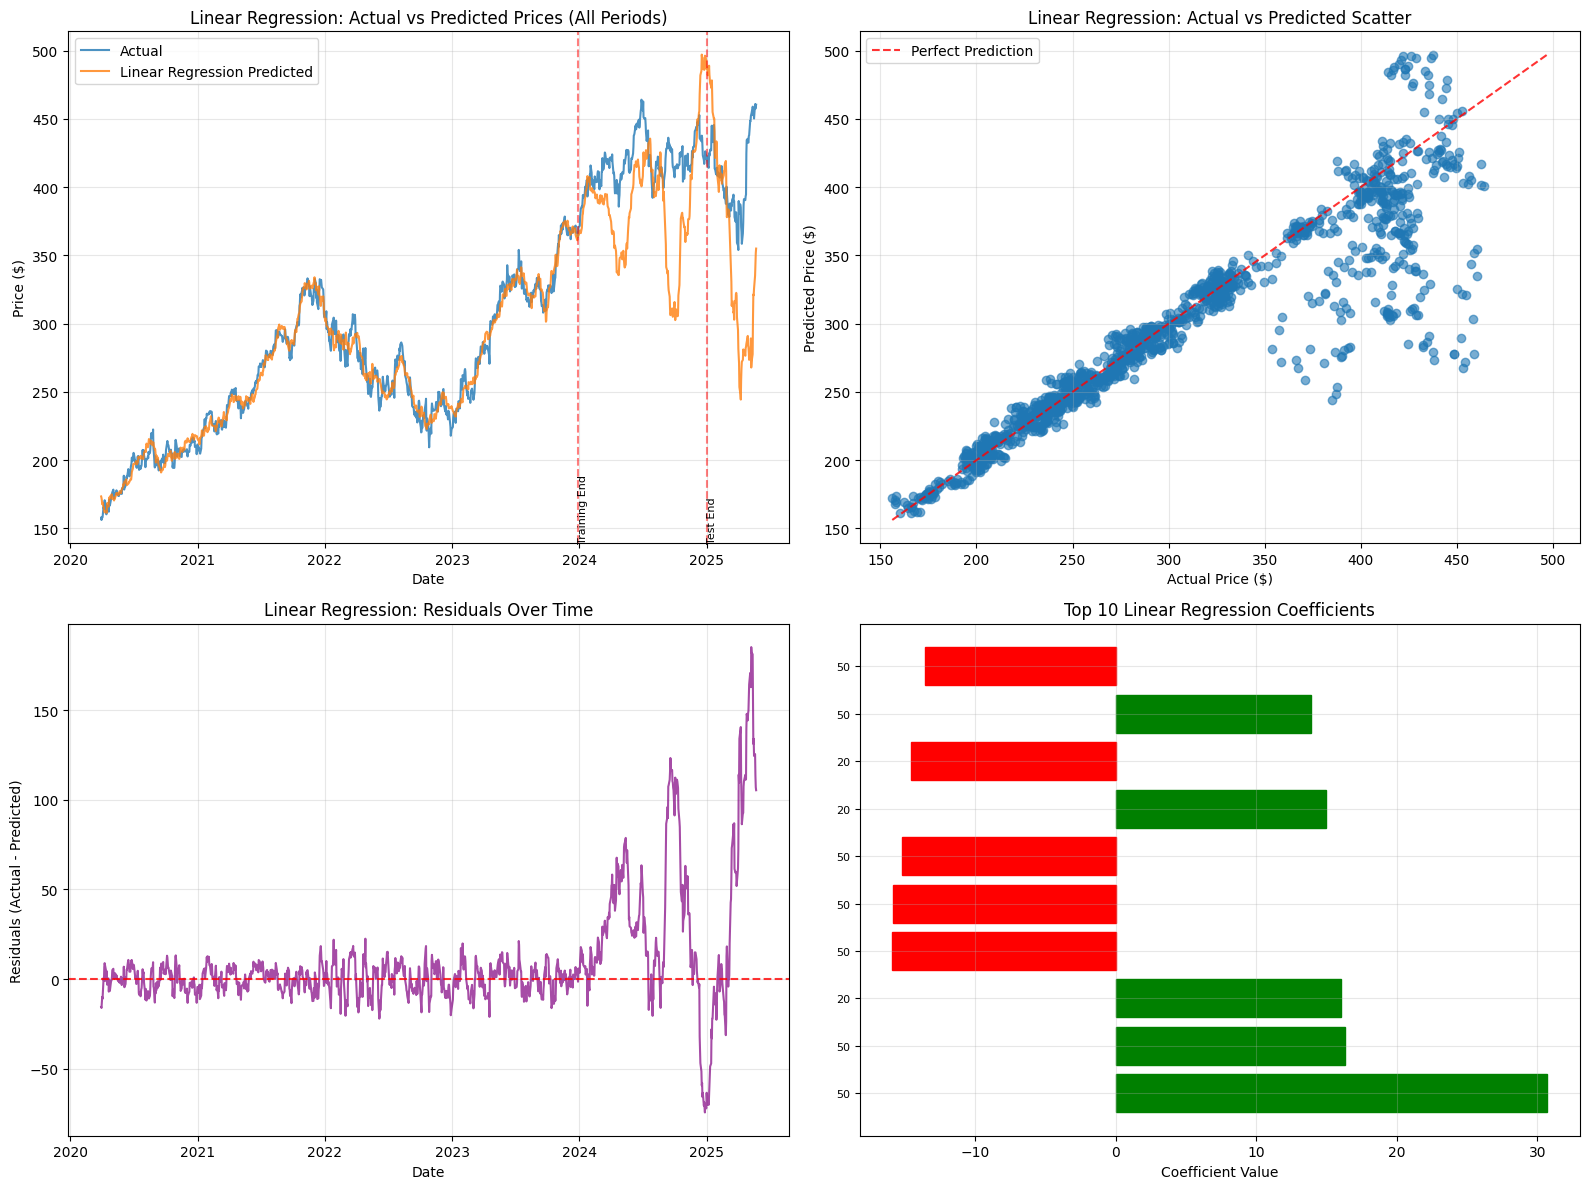


Selected Linear Regression Features (40):
 1. MSFT_Close_sma_20                        Coefficient:  11.7500
 2. MSFT_High_sma_20                         Coefficient:  -6.6409
 3. MSFT_Low_sma_20                          Coefficient:  -4.5748
 4. AAPL_Close_sma_10                        Coefficient:  -2.8686
 5. AAPL_Low_sma_10                          Coefficient:   2.7347
 6. AAPL_Close_sma_20                        Coefficient:  16.0184
 7. AAPL_High_sma_20                         Coefficient: -10.7996
 8. AAPL_Low_sma_20                          Coefficient:  -5.3391
 9. AMZN_Close_sma_20                        Coefficient:  -6.7866
10. AMZN_High_sma_20                         Coefficient:   2.5930
11. AMZN_Low_sma_20                          Coefficient:   4.0965
12. GOOGL_Close_sma_20                       Coefficient:  -7.6714
13. GOOGL_High_sma_20                        Coefficient:   7.3873
14. GOOGL_Close_sma_50                       Coefficient:   6.4621
15. GOOGL_High_sma_

In [8]:

# Visualizations (keep the existing visualization code)
print("\n=== LINEAR REGRESSION VISUALIZATIONS ===")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Combine all clean targets and predictions for plotting
all_actual_clean = pd.concat([y_train_clean, y_test_clean, y_strategy_clean]).sort_index()
all_predictions_lr = pd.concat([
    lr_predictions_rfe['training'], 
    lr_predictions_rfe['test'], 
    lr_predictions_rfe['strategy']
]).sort_index()

# Main time series plot
ax1 = axes[0, 0]
ax1.plot(all_actual_clean.index, all_actual_clean.values, label='Actual', alpha=0.8, linewidth=1.5)
ax1.plot(all_predictions_lr.index, all_predictions_lr.values, label='Linear Regression Predicted', alpha=0.8, linewidth=1.5)

# Add period separators
period_dates = {
    'Training End': y_train_clean.index[-1] if len(y_train_clean) > 0 else None,
    'Test End': y_test_clean.index[-1] if len(y_test_clean) > 0 else None
}

for label, date in period_dates.items():
    if date is not None:
        ax1.axvline(x=date, color='red', linestyle='--', alpha=0.5)
        ax1.text(date, ax1.get_ylim()[0], label, rotation=90, verticalalignment='bottom', fontsize=8)

ax1.set_title('Linear Regression: Actual vs Predicted Prices (All Periods)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted
ax2 = axes[0, 1]
ax2.scatter(all_actual_clean.values, all_predictions_lr.values, alpha=0.6)
min_val = min(all_actual_clean.min(), all_predictions_lr.min())
max_val = max(all_actual_clean.max(), all_predictions_lr.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, label='Perfect Prediction')
ax2.set_xlabel('Actual Price ($)')
ax2.set_ylabel('Predicted Price ($)')
ax2.set_title('Linear Regression: Actual vs Predicted Scatter')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Residuals over time
ax3 = axes[1, 0]
residuals_lr = all_actual_clean.values - all_predictions_lr.values
ax3.plot(all_actual_clean.index, residuals_lr, alpha=0.7, color='purple')
ax3.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax3.set_title('Linear Regression: Residuals Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Residuals (Actual - Predicted)')
ax3.grid(True, alpha=0.3)

# Feature coefficients
ax4 = axes[1, 1]
coef_df = pd.DataFrame({
    'Feature': selected_features_rfe,
    'Coefficient': lr_final_rfe.coef_
}).sort_values('Coefficient', key=abs, ascending=False).head(10)

bars = ax4.barh(range(len(coef_df)), coef_df['Coefficient'])
ax4.set_yticks(range(len(coef_df)))
ax4.set_yticklabels([f.split('_')[-1] for f in coef_df['Feature']], fontsize=8)
ax4.set_xlabel('Coefficient Value')
ax4.set_title('Top 10 Linear Regression Coefficients')
ax4.grid(True, alpha=0.3)

# Color bars by sign
for i, bar in enumerate(bars):
    if coef_df['Coefficient'].iloc[i] >= 0:
        bar.set_color('green')
    else:
        bar.set_color('red')

plt.tight_layout()
plt.show()

# Print Linear Regression feature details
print(f"\nSelected Linear Regression Features ({len(selected_features_rfe)}):")
for i, feature in enumerate(selected_features_rfe):
    coef = lr_final_rfe.coef_[i]
    print(f"{i+1:2d}. {feature:40s} Coefficient: {coef:8.4f}")

# Summary of Linear Regression Performance
print(f"\n=== LINEAR REGRESSION SUMMARY ===")
print("Performance across periods:")
for period, period_metrics in lr_metrics_rfe.items():
    print(f"{period.capitalize():10s}: R² = {period_metrics['r2']:.4f}, MSE = {period_metrics['mse']:.4f}")